# A skelleton to a Hartree-Fock (HF) code

The following notebook gives an outline to a complete restricted HF code.
As usual we start by importing some modules. To do so we first download the file containing some of these.

In [1]:
!pip install scipy==1.9.3
!pip install numpy==1.23.5

In [2]:
!wget https://raw.githubusercontent.com/jollactic/Modelling_course/main/HF/HF_helper_functions.py

--2024-03-21 08:26:06--  https://raw.githubusercontent.com/jollactic/Modelling_course/main/HF/HF_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11775 (11K) [text/plain]
Saving to: ‘HF_helper_functions.py.1’

HF_helper_functions 100%[===================>]  11.50K  --.-KB/s    in 0s      

2024-03-21 08:26:06 (74.6 MB/s) - ‘HF_helper_functions.py.1’ saved [11775/11775]



Joshua Goings has prepared a very nice set of python functions that allow us to compute integrals involving Gaussian functions:

$$
\\
\mathbf{S}_{ab}=\left \langle \phi_a|\phi_b  \right \rangle
\\
\mathbf{T}_{ab}=-\frac{1}{2}\left \langle \phi_a|\nabla^2 |\phi_b  \right \rangle
\\
\mathbf{V}_{ab}= \sum_{k}^{M} \left \langle   \phi_a \left |  \ \frac{Z_k}{\left | \textbf{R}_k-\textbf{r} \right| }  \right | \phi_b \right \rangle  
\\
\\
\mathbf{J}_{abcd}= \int \int \phi_a(\textbf{r}_1)\phi_b(\textbf{r}_1) r_{12}^{-1} \phi_c(\textbf{r}_2)\phi_d(\textbf{r}_2) d\textbf{r}_1d\textbf{r}_2
\\
\mathbf{K}_{abcd}= \int \int \phi_a(\textbf{r}_1)\phi_c(\textbf{r}_1) r_{12}^{-1} \phi_b(\textbf{r}_2)\phi_d(\textbf{r}_2) d\textbf{r}_1d\textbf{r}_2
\\
$$




In [3]:
from HF_helper_functions import BasisFunction, S_ab, V_ab, T_ab, TwoE
#TwoE can be used to calculate both J and K.

'''
The intergral and basis-sets tools are written Joshua Goings under the following licence:

# BSD 3-Clause License
# Copyright (c) 2021, Joshua Goings
# All rights reserved.

'''
import numpy as np
import matplotlib.pyplot as plt


# Specifying our system
Below is a simple example demonstrating how to define a hydrogen with a so-called STO-2G basis-set.

In [4]:
#############
#Hydrgen atom
R_i=[[0,0,0]] # List of atom centers
Z_i=[1.0]     # List of nuclear charges
N=2           # Number of electrons (EVEN NUMBER REQUIRED FOR RESTRICED HF)

basis_set=[]  # Basis-set

#Use this construction to add basis functions
#You can essentially add as many as you like but the codes will become slower and slower.
#Shell [0,0,0] correspond to 1s orbitals, i.e. they a spherical and have no nodes along r
#Origin [0,0,0] means that our basis-function is centered around origi (note this is the same as our nuclie)
basis_set.append ( BasisFunction(origin=[0,0,0],shell=[0,0,0],exps=[0.151623,0.851819],coefs=[0.678914,0.430129]) )

M=len(basis_set)               #Number of basis-functions counted using the 'len' function
global index;index=range(M)    #index store the indeces of the basis functions. Convient in for-loops.



# Plotting our basis-functions
In the simple example below we can plot a basis-function and comparison it to the to the exact solution for a H1s electron.  


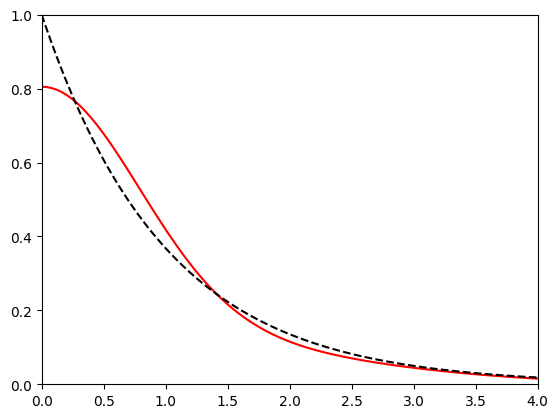

In [5]:
def eval_basis(b,r):
    '''
    Takes a list of distance a returns the value of the radial part of basis-function.
    '''
    vals=[]
    for rr in r:
        val=0
        for nrm,c,ex in zip(b.norm,b.coefs,b.exps):
            val += nrm*np.exp( -rr**2*ex )
        vals.append(val)
    return(vals)

def H1s(r):
    '''
    Takes a list of distance a returns the radial part of H1s, exact solution to the Schrödring eq.
    '''
    vals=[]
    for rr in r:
        val = (1/1)**0.5*np.exp( -rr)
        vals.append(val)
    return(vals)

r=np.linspace(0,4, 100)
plt.xlim(0,4)
plt.ylim(0,1)
plt.plot(r, eval_basis(basis_set[0],r), color='red')
plt.plot(r, H1s(r), '--',color='black')


# Setting up the matrices
The Roothan-Hall equations is a set of linear equation involving matrices. The matrix elements consists of various integrals involving our basis-functions. Since we are using a Gaussian basis all of these integrals have known analytic solutions. The functions S_ab, V_ab, etc. can be used to obtain these analytical values. The imput to these functions is simply two (sometimes four) basis-function.





In [ ]:
from HF_helper_functions import S_ab, V_ab, T_ab, TwoE

F=np.zeros([M,M])     #FOCK-MATRIX
T=np.zeros([M,M])     #KINETIC ENERGY MATRIX
S=np.zeros([M,M])     #OVERLAP MATRIX
V=np.zeros([M,M])     #NECLOUS ATTRACTION MATRIX
J=np.zeros([M,M,M,M]) #COULOMB ELEMENTS
K=np.zeros([M,M,M,M]) #EXCHANGE ELEMENTS
P=np.zeros([M,M])     #DENSITY MATRIX
C=np.zeros([M,M])     #COEFFICIENT MATRIX
eps=np.zeros([M])   #ORBITAL ENERGIES (EIGENVALUES TO THE FOCK-MATRIX)
#Where M is the number of basis-function


#FILLING IN THE MATRICES

#Example: overlap matrix
for a,basis_func_a in zip(index,basis_set): #With zip we can get both the index and basis-function to work with in our loop
    for b,basis_func_b in zip(index,basis_set):
        S[a,b]=S_ab(basis_func_a,basis_func_b)
        #This returns the overlap integral for basis-functions, basis_func_a and basis_func_b, and writes them into matrix element a,b of S

# Filling in the rest
Your first real task is to make the loops to fill in the other matrices. Note that, F, C, P, and eps cannot be fill out yet.

In [ ]:
#Make loops to fill in matrices

# Setting up the work-flow
I order to solve the Roothan-Hall equations we should follow the proceedure:

1. Guess $\mathbf{C}$
2. Calculate $\mathbf{F}$ from $\mathbf{C}$
3. Make a linear transformation of $\mathbf{F}$ using $\mathbf{S}^{-\frac{1}{2}}$
4. Solve $\mathbf{F}' \mathbf{C}'=\mathbf{C}'\mathbf{E}$
5. Transform $\mathbf{C}'$ to $\mathbf{C}$, again using $\mathbf{S}^{-\frac{1}{2}}$
6. Calculate $\mathbf{F}$
7. Repeat steps 3-6 until we reach a self consistent field, i.e when $\mathbf{C}$ does not change anymore.

When calculating $\mathbf{F}$ it is very useful to make use of the denisty matrix $\mathbf{P}$ which is easy to compute from $\mathbf{C}$. We can use the following formula to fill $\mathbf{F}$.


$$
\\
\mathbf{F}_{ab}=\mathbf{T}_{ab}+\mathbf{V}_{ab}+ \sum_{c}^{N_{basis}}\sum_{d}^{N_{basis}}  \mathbf{P}_{cd}\left [  \mathbf{J}_{abcd}-\frac{1}{2}\mathbf{K}_{abcd} \right ]
\\
$$


In [ ]:
#Use this function to get eigenvalues and eigenvector from a matrix
#The function makes sure to return eigenvalues in ascending order
#which is very useful for determining which columns of C that corresponds
#to the occupied orbitals.
def eigenval(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors


#The following few lines computes X=S^(-1/2)
D,U =eigenval(S)
D=np.diag(1/D**0.5)
UD=np.matmul(U,D)
X=np.matmul(UD,U.T)


#Total energy can be computed using the following loop.
#It is often instructive to follow the change in total-energy
#as a function of cycles in the SCF proceedure.
total_E=0.0
for i in range(M):
    for j in range(M):
        total_E += 0.5*P[i,j]*(T[i,j] +V[i,j] + F[i,j])
print("Total electronic energy: ",total_E)



#Here is where you put down your work-flow





Total electronic energy:  0.0


# Below is a prototype for plotting the orbitals
Note that the function only works for 1s basis-functions.

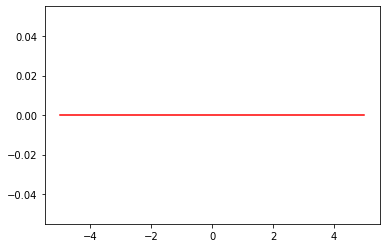

In [ ]:
@np.vectorize
def eval_rho(x, y, elec=0):
    rho=0.0
    rr = [0,x,y]
    for a,basis_func in zip(index,basis_set):
        d=np.linalg.norm(basis_func.origin-rr)
        for nrm,c,ex in zip(basis_func.norm,basis_func.coefs,basis_func.exps):
            rho += C[a,elec]*nrm*c*np.exp( -d**2*ex  )
    return rho

f, axs = plt.subplots(2,2, sharex=True, sharey=False)


r=[]
y_grid = np.linspace(-4,4, 100)
z_grid = np.linspace(-4,4, 100)
y, z = np.meshgrid(y_grid,z_grid)
rho = eval_rho(y, z,elec=0)

axs[0,0].contour(y, z, rho)
axs[0,0].set_aspect(1)
axs[0,0].grid()
axs[0,1].plot(z[:,50], rho[:,50])

rho = eval_rho(y, z, elec=1)
axs[1,0].contour(y, z, rho)
axs[1,0].set_aspect(1)
axs[1,0].grid()
axs[1,1].plot(z[:,50], rho[:,50])

axs[0,0].set_ylabel('z')
axs[1,0].set_ylabel('z')
axs[1,0].set_xlabel('y')
axs[1,1].set_xlabel('z')
